# Computational Social Science Project #2 

**Enter your Name:** Rachel Pizatella-Haswell

**Group:** I worked with Sam Ayers. I also asked Brenda Sciepura and Omair Gill some questions.

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict

# use random seed for consistent results 
np.random.seed(273)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("/Users/rachelhaswell/Documents/soc273/projects/Project 2/data prep/Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
## # identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [6]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 

['No Data']


In [7]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [8]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 


In [9]:
# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 


In [10]:
# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


In [11]:
diabetes[['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number']].dtypes

Diabetes_Number               int64
Obesity_Number                int64
Physical_Inactivity_Number    int64
dtype: object

In [12]:
# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

In [13]:
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].head()

0    76.5
1    86.6
2    76.2
3    80.5
4    79.7
Name: sex and age_total population_65 years and over_sex ratio (males per 100 females), dtype: float64

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [14]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [15]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
diabetes_summary

,count,mean,std,min,25%,50%,75%,max
Diabetes_Number,3112.0,0.092857,0.028097,0.019038,0.072169,0.089291,0.110175,2.242079e-01
Obesity_Number,3112.0,0.251666,0.044323,0.088946,0.223436,0.252390,0.280113,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.044511,0.064949,0.170128,0.199036,0.231041,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,10.347722,34.700000,78.300000,82.600000,88.400000,2.200000e+02
race_total population,3112.0,103682.624036,331362.542093,228.000000,11226.750000,26137.500000,68477.250000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.019379,0.713126,0.971038,0.980119,0.986630,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.019379,0.000000,0.013370,0.019881,0.028962,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.019379,0.713126,0.971038,0.980119,0.986630,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.167534,0.038912,0.767171,0.896086,0.950193,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.144287,0.000000,0.006815,0.022927,0.101805,8.741228e-01


In [16]:
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [17]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes)) ## check: is this the right df?
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_18 years and over_1',
 'race_total population_one race_1',
 'hispanic or latino and race_total population',
 'sex and age_total population',
 'sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1']

In [18]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

In [19]:
diabetes

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [20]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
print(diabetes['Region'])


0       Southeast
1       Southeast
2       Southeast
3       Southeast
4       Southeast
          ...    
3215         West
3216         West
3217         West
3218         West
3219         West
Name: Region, Length: 3112, dtype: object


## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

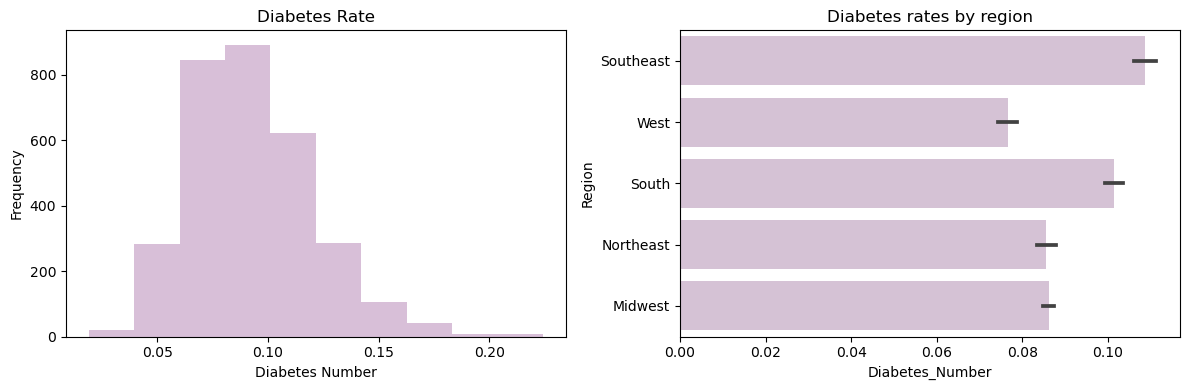

In [21]:
#
# EDA #1 and interpretations in this section 
#-----------
# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Histogram of 'Diabetes_Number'
ax1.hist(diabetes['Diabetes_Number'], color='thistle')
ax1.set_xlabel('Diabetes Number')
ax1.set_ylabel('Frequency')
ax1.set_title('Diabetes Rate')

# Diabetes Region
sns.barplot(x="Diabetes_Number", y="Region", data=diabetes, color="thistle", ax=ax2)
ax2.set_title('Diabetes rates by region')

# Show plots
plt.tight_layout()
plt.show()


**Diabetes by region**

The figure on the left is a histogram of diabetes rates. The figure on the right disaggregates diabetes rates by region. The southeast and south regions have the highest diabetes rates in the country. 

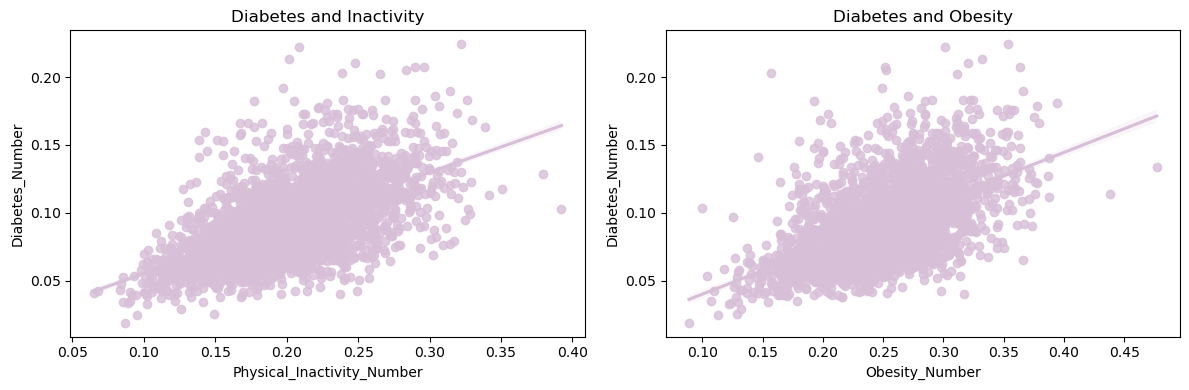

In [22]:
#
# EDA #2 and interpretations in this section 
#-----------
# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Diabetes and Inactivity
sns.regplot(x = diabetes['Physical_Inactivity_Number'],
           y = diabetes['Diabetes_Number'],color="thistle", ax=ax1)
ax1.set_title('Diabetes and Inactivity')

# Diabetes and Obesity
sns.regplot(x = diabetes['Obesity_Number'],
           y = diabetes['Diabetes_Number'], color="thistle", ax=ax2)
ax2.set_title('Diabetes and Obesity')

# Show plots
plt.tight_layout()
plt.show()


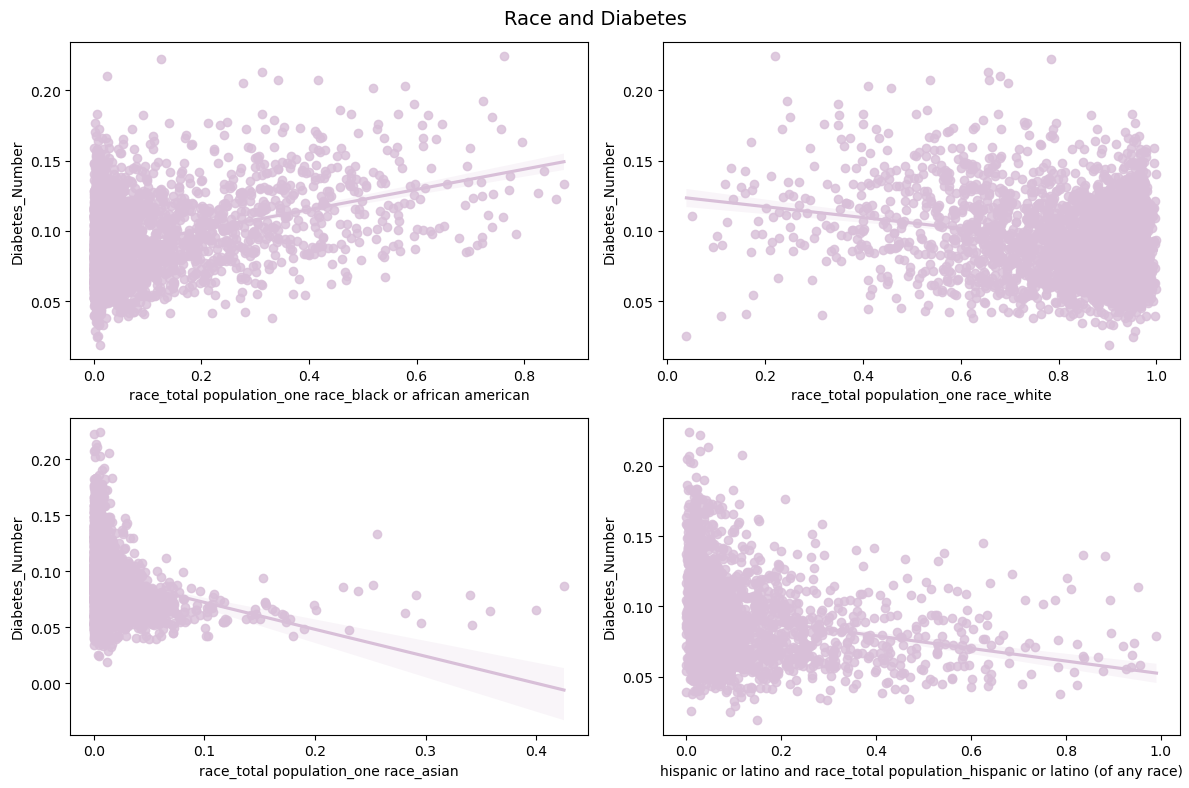

In [23]:
# Create four separate subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Black
sns.regplot(x = diabetes['race_total population_one race_black or african american'],
           y = diabetes['Diabetes_Number'],color="thistle", ax=axs[0, 0])

# White
sns.regplot(x = diabetes['race_total population_one race_white'],
           y = diabetes['Diabetes_Number'],color="thistle", ax=axs[0, 1])

# Asian
sns.regplot(x = diabetes['race_total population_one race_asian'],
           y = diabetes['Diabetes_Number'],color="thistle", ax=axs[1, 0])


# Hispanic
sns.regplot(x = diabetes['hispanic or latino and race_total population_hispanic or latino (of any race)'],
           y = diabetes['Diabetes_Number'],color="thistle", ax=axs[1, 1])


# Show plots
plt.suptitle('Race and Diabetes', fontsize=14)
plt.tight_layout()
plt.show()


**Diabetes by race**

The figures above are scatterplots with a line of best fit to illustrate the relationship between diabetes rates by race. Race is measured as a porportion. African American is in the top left, white is in the top right, Asian is in the bottm left and hispanic is in the bottom right. Higher proportions of white, asian and hispanic identifying citizens are associated with decreased diabetes rates. Higher proportions of African Americans is associated with higher diabetes rates. 

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [24]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

**Purpose of each set**: 
Supervised machine learning uses a dataset with observations containing an outcome variable of interest known as a label and covariates known as features. The goal of machine learning is to fit a model to the data that uses the features to accurately predict the outcome. 

Models fit like this can encounter a problem of overfitting whereby the model is good at predicting the available sample data but could not generalize to out of sample data because it captures too much of the irrelevant noise in the available data. To assess the extent a model is prone to this problem, and make corrections, we always split the sample data before training the model.

Data used for machine learning is typically split into three distinct sets (60/20/20 split) used for training, model tuning, and final evaluation. 

**Training Set:**: is used to train the model and typically contains 60% of the sample data. Training the data means adjusting model parameters to minimize error between prediction (produced from the model) and actual data (in the real world which we can observe in the validation and test data but not in other generalized applications). 

**Validation Set:** Is used to tune hyperparameters, test model performance and select the best-performing model. It typically contains 20% of the sample data. The model has not seen this data during the training phase. 

**Test Set:** Is used to test model performance for generalizability purposes in real world applications. It typically contains 20% of the sample data but acts like out of sample data. The test set is held back until the model is ready for testing. 

In [25]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number', 'race alone or in combination with one or more other races_total population'], 
                axis = 1) 

In [26]:
#
# Feature selection
#-----------
# examine variables 
print(diabetes_clean.columns)


Index(['CountyFIPS', 'Diabetes_Number', 'Obesity_Number',
       'Physical_Inactivity_Number',
       'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
       'race_total population', 'race_total population_one race',
       'race_total population_two or more races',
       'race_total population_one race_white',
       'race_total population_one race_black or african american',
       'race_total population_one race_american indian and alaska native',
       'race_total population_one race_american indian and alaska native_cherokee tribal grouping',
       'race_total population_one race_american indian and alaska native_chippewa tribal grouping',
       'race_total population_one race_american indian and alaska native_navajo tribal grouping',
       'race_total population_one race_american indian and alaska native_sioux tribal grouping',
       'race_total population_one race_asian',
       'race_total population_one race_asian_asian indian',
       

In [27]:
# drop location variables except for region
X = diabetes_clean.drop(['Diabetes_Number', 
                         'race alone or in combination with one or more other races_total population',
                        'CountyFIPS'], 
                axis = 1) 

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [28]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.80,      # specify proportional split for training
                                                    test_size=0.20)       # specify proportional split for test

In [29]:
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X test is", X_test.shape)
print("Shape of y test is", y_test.shape)

Shape of X train is (2489, 88)
Shape of y_train is (2489,)
Shape of X test is (623, 88)
Shape of y test is (623,)


In [30]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train, y_train, 
                                                             train_size=0.75,
                                                             test_size=0.25)

# 75% of the training set = 60% of the whole set 

In [31]:
# use .shape to check out how many rows and columns you have in your train and test data
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of y_validate is", y_validate.shape)

Shape of X train is (1866, 88)
Shape of y_train is (1866,)
Shape of X_validate is (623, 88)
Shape of y_validate is (623,)


In [32]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** 

**Linear regression:**
For a set of data points (x, y) where x is the independent variable and y is the dependent variable, OLS fits a linear model of the form (y = mx + b) that minimize the sum of the squared differences between the observed y-values and the predicted y-values. 

Thus the OLS optimization function is 
$$
RSS = ∑(yᵢ - ŷᵢ)²
$$

OLS assumptions include: 

Linearity: The relationship between the independent and dependent variable is linear.

Full rank/identification: There are not more regressors than observations.

Strict exogeneity: None of the Xs contain any information about the residuals. 

Spherical error variance: No auto-correlation and homoskedasticity


**Ridge:** Ridge regression adds a penalty term to the linear regression cost function. The penalty term is the sum of the squares of the coefficients, and it is weighted by a hyperparameter (λ). 

The Ridge regression function is :
$$
J(W) = RSS + λ Σ(Wi^2)
$$

Ridge regression assumes multicollinearity and addresses overfitting. 

**LASSO:** Lasso regression uses a different penalty term. Instead of the sum of squares of the coefficients, it uses the absolute values of the coefficients. 

The Lasso regression function is :
$$
Lasso Function = RSS + λ Σ|Wi|
$$

Ridge regression assumes multicollinearity and addresses overfitting. However, unlike Ridge, it can shrink the coefficients to 0, which creates a "Sparse" model that is easier to interpret (because it just drops features). 

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  OLS

**Train**

In [33]:
#
# Model 1 training
#-----------
lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)


**Tune**

In [34]:
# tune hyperparameters using grid search
param_grid = {'fit_intercept': [True, False]}      

# execute the grid search
lin_grid_reg = GridSearchCV(estimator  = lin_reg,        # model to be tuned
                            param_grid = param_grid,     # parameters to be searched as specified above
                            cv=3,                        # 3-fold cross-validation to be used during hypertuning
                            refit = True)

# now fit the tuning on the training data
lin_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset
best_index_lin = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_lin_pred_train = lin_grid_reg.best_estimator_.predict(X_train)     # find best estimator and predict on validate


**Performance stats**

In [35]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [36]:
# performance stats - by hand
ssr = np.sum((y_train - best_lin_pred_train)**2)
sst = np.sum((y_train - np.mean(y_train))**2)
lin_r2 = 1 - (ssr/sst)
print(lin_r2)

0.53911869801914


In [37]:
# performance stats 
print(lin_grid_reg.cv_results_["params"][best_index_lin])
print('OLS - Training R^2:', lin_grid_reg.score(X_train, y_train))
print('OLS - Training RMSE', rmse(best_lin_pred_train, y_train))

{'fit_intercept': True}
OLS - Training R^2: 0.53911869801914
OLS - Training RMSE 0.019615203304864992


#### Model 2:  Ridge

**Train**

In [38]:
#
# Model 2 training
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


**Tune**

In [39]:
#
# RIDGE 
#-----------
# We will run 9*2*4 = 72 tests, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index_ridge = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred_train = ridge_grid_reg.best_estimator_.predict(X_train)   # find best estimator and predict on validate


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


**Performance stats**

In [40]:
#performance stats
print(ridge_grid_reg.cv_results_["params"][best_index_ridge])
print('Ridge - Training R^2:', ridge_grid_reg.score(X_train, y_train))
print('Ridge - Training RMSE', rmse(best_ridge_pred_train, y_train))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'lsqr'}
Ridge - Training R^2: 0.5402263215621091
Ridge - Training RMSE 0.019591618783069555


#### Model 3:  LASSO

**Train**

In [41]:
#
# Model 3 training
#-----------
# create and fit the model
lasso_reg = Lasso(max_iter=150000, alpha=.001)
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

**Tune**

In [42]:
#
# LASSO 
#----------- 

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index_lasso = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])   # find the best performing model
best_lasso_pred_train = lasso_grid_reg.best_estimator_.predict(X_train)    # find best estimator and predict on validate


**Performance stats**

In [43]:
# performance stats
print(lasso_grid_reg.cv_results_["params"][best_index_lasso])
print('Validation R^2:', lasso_grid_reg.score(X_train, y_train))
print('Validation RMSE', rmse(best_lasso_pred_train, y_train))

{'alpha': 0.1, 'fit_intercept': True, 'selection': 'cyclic'}
Validation R^2: 0.0
Validation RMSE 0.02889337466987909


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

### OLS

In [44]:
#
# Predict on validation data
#-----------
# select the best performing model and predict with that on validation dataset
best_lin_pred_validate = lin_grid_reg.best_estimator_.predict(X_validate)     # find best estimator and predict on validate

In [45]:
# print the results  
print('OLS - Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('OLS - Validation RMSE', rmse(best_lin_pred_validate, y_validate))

OLS - Validation R^2: -1.3978452690910762e+23
OLS - Validation RMSE 9730448471.677229


### Ridge

In [46]:
# select the best performing model and predict with that on validation dataset 
best_ridge_pred_validate = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

In [47]:
# print the results  
print('Ridge - Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Ridge - Validation RMSE', rmse(best_ridge_pred_validate, y_validate))

Ridge - Validation R^2: 0.43633360340765037
Ridge - Validation RMSE 0.01953954196760761


### LASSO

In [48]:
# select the best performing model and predict with that on validation dataset 
best_lasso_pred_validate = lasso_grid_reg.best_estimator_.predict(X_validate)    # find best estimator and predict on validate

In [49]:
# print results
print('LASSO - Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('LASSO - Validation RMSE', rmse(best_lasso_pred_validate, y_validate))

LASSO - Validation R^2: -0.006165678756800741
LASSO - Validation RMSE 0.026105863098580453


### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

**Advantage of using both validation and test sets**
It is good practice to save the test set until the very end and only use it once. Thus, we construct a validation set to accompany the training set as a way to test the model. Constructing and using a validation and test set has the following benefits

**Model Selection and Hyperparameter Tuning:** The validation set is used to select the best model and tune the hyperparameters. By training multiple models and evaluating their performance on the validation set, you can choose the best one before testing its performance on the test set. 

**Prevent Overfitting:** Overfitting means the model may not perform well on out of sample data. The validation step tunes the hyperparameter in order to avoid this problem. 

**Measure Performance and Generalization:** The test set mimics out of sample data as it is not seen by the model until the very end. Thus, it can be used to test the best model which would have been selected during the training and validation steps. The test set is used to estimate how well the model is expected to perform in real-world applications.


**Performance and model choice**

I think that the ridge classifer is showing the best performance. However, I think that is likely due to multicollinearity that is underfitting the LASSO model. I still think LASSO will be the easiest to interpret, so I am moving forward with that model. 

In [50]:
#
# Predict using your best model
#-----------
# pick the best estimator and predict on test
best_pred_test = lasso_grid_reg.best_estimator_.predict(X_test)

In [51]:
# print various results
print('Test R^2:', lasso_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred_test, y_test))

Test R^2: -0.0050656239147992554
Test RMSE 0.027630758759029456


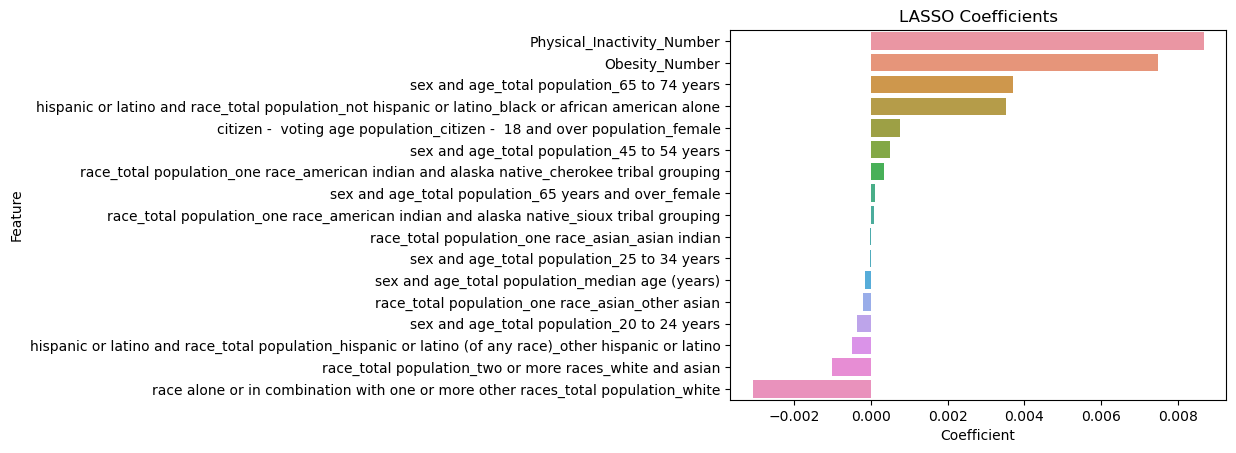

In [52]:
# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

# remove features that equal 0
lasso_reg_data = lasso_reg_data[lasso_reg_data['Coefficient'] != 0]

# sort
lasso_reg_data = lasso_reg_data.sort_values(by='Coefficient', ascending=False)

# specify barplot for LASSO 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lasso_reg_data).set_title("LASSO Coefficients")

# show the plot
plt.show()

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

**Cross-validate K choice** 

The cross-validation procedure is:

1. Randomly split the data into k-folds
2. Build the model on k-1 folds, then test on the last fold
3. Record prediction error
4. Cycle until each fold has served as the test set
5. The average of the errors is the cv-error

Cross-validation helps to address the consequences of random variation across sets. Completing this process means that every observation is in the test set at least once. Thus, it helps deal with overfitting because the model is less sensitive to random noise in each sample. 

One decisions that the cross-validation approach requires is choosing the number of folds, K, into which the data is partitioned. Typically k=5 or k=10. There are pros and cons of smaller vs. larger k's, and the number of k's will depend on the sample data to some extent. 

**Smaller values of K**

Smaller k (e.g., 2 or 3) leads to higher variance in the performance estimate. Each fold has a larger portion of the data, which may result in the model's performance being sensitive to the particular split.

If you have limited data, a small value of k (e.g., 2 or 3) might be necessary to ensure that each fold has a sufficient amount of data for training and testing.

Smaller values of k result in a larger proportion of the data being used for training, which may improve the model's learning process. However, this comes at the cost of a less reliable estimate of the model's performance.

**Larger values of K** 

Larger k (e.g., 10 or more) provides a more stable and less biased performance estimate. However, it can be computationally expensive, especially when dealing with large datasets.

Larger values of k may be harder to interpret because it is difficult to compare across k sets. 

In [53]:
#
# Run cross-validation
#-----------

In [54]:
# Create training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, train_size=0.8, test_size=0.2)

# Create a list of feature names before standardization
feature_names = X.columns

# Standardize the data
new_scaler = StandardScaler().fit(X_train_new)
X_train_new = new_scaler.transform(X_train_new)
X_test_new = new_scaler.transform(X_test_new)

In [55]:
# predict 
lasso_cv_model = LassoCV(cv=5, random_state=0, max_iter=10000)
lasso_cv_model.fit(X_train_new, y_train_new)

# use cross_val_predict to get cross-validated predictions
lasso_new_predictions = cross_val_predict(lasso_cv_model, X_train_new, y_train_new, cv=5)

# find the best alpha 
best_alpha = lasso_cv_model.alpha_

# use the best Lasso model with the selected alpha
best_lasso_model = Lasso(alpha=best_alpha)
best_lasso_model.fit(X_train_new, y_train_new)

# pedict on the validation dataset using the best model
best_lasso_pred_train_new = best_lasso_model.predict(X_train_new)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [57]:
# Calculate R-squared and RMSE on the best Lasso model
best_lasso_r2 = r2_score(y_train_new, best_lasso_pred_train_new)
best_lasso_rmse = np.sqrt(mean_squared_error(y_train_new, best_lasso_pred_train_new))

# Print R-squared and RMSE for the best Lasso model
print('Best Lasso R^2:', best_lasso_r2)
print('Best Lasso RMSE:', best_lasso_rmse)

Best Lasso R^2: 0.5170526034198955
Best Lasso RMSE: 0.019503320208081206


In [58]:
# Get the non-zero coefficients and corresponding feature names
non_zero_coefficients = best_lasso_model.coef_

# Create a list of covariates with non-zero coefficients
non_zero_covariates = [X_train_new.columns[i] for i in range(len(non_zero_coefficients)) if non_zero_coefficients[i] != 0]

# Print the covariates with non-zero coefficients
print('Covariates with non-zero coefficients:')
for covariate in non_zero_covariates:
    print(covariate)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [60]:
# Get the non-zero coefficients and their corresponding indices
non_zero_indices = np.where(non_zero_coefficients != 0)[0]

# Print the coefficients and feature names for the non-zero coefficients
print('Coefficients and corresponding feature names for non-zero coefficients:')
for index in non_zero_indices:
    coefficient = non_zero_coefficients[index]
    feature_name = feature_names[index]
    print(f'Feature: {feature_name}, Coefficient: {coefficient}')

Coefficients and corresponding feature names for non-zero coefficients:
Feature: Obesity_Number, Coefficient: 0.007404928126272536
Feature: Physical_Inactivity_Number, Coefficient: 0.007962950171169743
Feature: race_total population_one race_white, Coefficient: -0.0014949072391792564
Feature: race_total population_one race_black or african american, Coefficient: 0.002721999584610726
Feature: race_total population_one race_american indian and alaska native_cherokee tribal grouping, Coefficient: 0.0008085134884605731
Feature: race_total population_one race_american indian and alaska native_navajo tribal grouping, Coefficient: 0.000983122954898195
Feature: race_total population_one race_american indian and alaska native_sioux tribal grouping, Coefficient: 0.0014616069189311914
Feature: race_total population_one race_asian_asian indian, Coefficient: -0.0001789519323261595
Feature: race_total population_one race_asian_chinese, Coefficient: 7.268811637219958e-05
Feature: race_total populatio

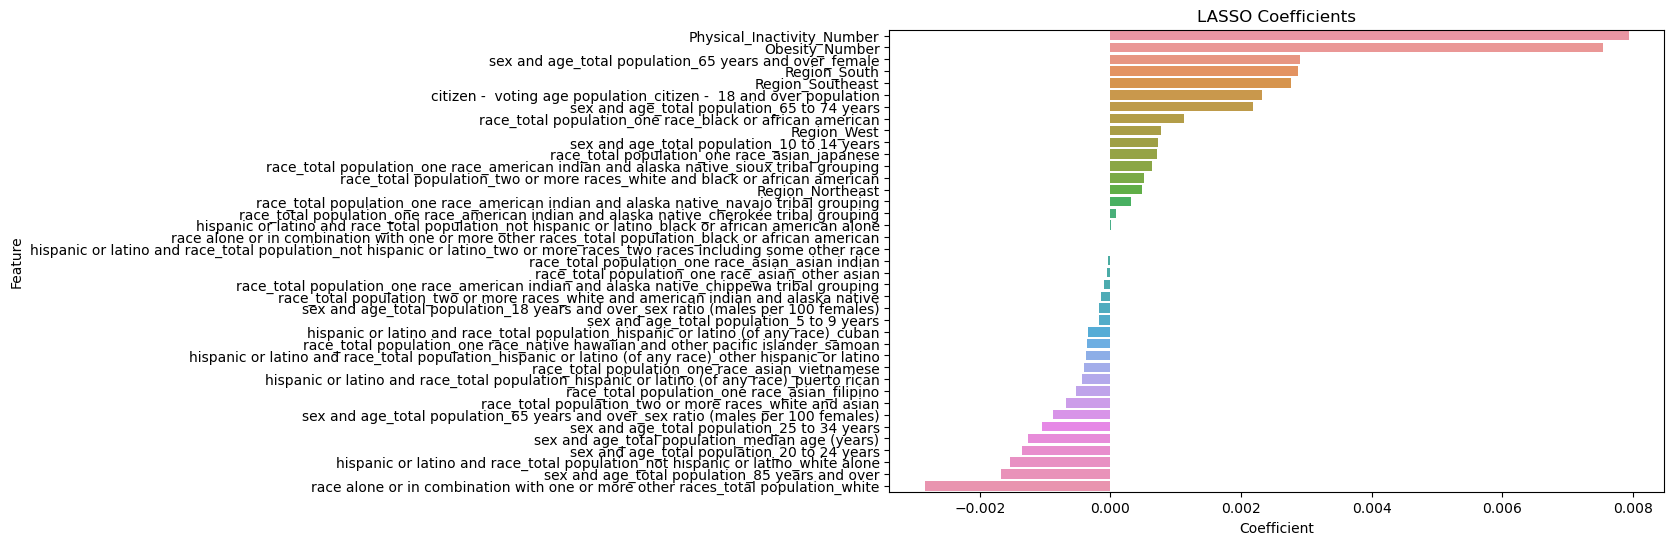

In [59]:
# Get the non-zero coefficients and their corresponding indices
non_zero_indices = np.where(non_zero_coefficients != 0)[0]

# Create a DataFrame with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame({'Coefficient': non_zero_coefficients[non_zero_indices], 
                               'Feature': [feature_names[i] for i in non_zero_indices]})

# Sort 
lasso_reg_data = lasso_reg_data.sort_values(by='Coefficient', ascending=False)

# Create a barplot for LASSO
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x='Coefficient', y='Feature', data=lasso_reg_data)
plt.title('LASSO Coefficients')

# Show the plot
plt.show()

## 6. Discussion Questions


### 6.1 What is the bias-variance tradeoff? Why is it relevant to machine learning poblems like this one?
You can decrease bias, or the degree to which the fitted values of your model differ from the actual values, by incorporating more information, or predictors, into your model. Doing this in a sample, there is some degree to which you are capturing the way the real world works, and some degree to which you are explaining random variation in your particular sample. If you include lots of predictors that explain random variation, then your predcition model will not be consitent when you use it on other samples since those new samples will have random variation that looks very different from your original data. This is is the bias-variance trade-off. This is relevant to machine learning because we care about creating prediction models that capture the way the world truly works, and that give us consistent and accurate predictions across models.

**YOUR ANSWER HERE**

There are two sources of error in modelling. 

**Bias:** is the difference between the predicted value or outcome given by the model and the actual value. Underfitting means there's high bias. 

**Variance:** is an error due to fitting random noise (as opposed to the real relationship). Overfitting means there's high variance. 

Decreasing bias increases variance. For example, adding features usually reduces bias but increases variance. 

A good model will have low bias and low variance, so that it generalizes well to new data. The process of tuning hyper-parameters and cross-validation help achieve balance between bias and variance. 

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**

**Overfitting** is when the test error is substantially worse than the training error because the classifier becomes too sensitive to irrelevant patterns in the training data. We want classifiers that generalize to new settings. 

**Regularization** prevents overfitting by adding a penalty for model complexity. Ridge and LASSO regression, for example, add a penalty term (with a hyperparamter) to the OLS cost function. We tune the hyperparameter as part of the validation step, and select the hyperparameter that has the lowest error rate in the validation and test data. 

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**

This project uses machine learning to understand diabetes rates. 

I first examines the correlational relationship between certain factors and diabetes and find the the south and southest, high levels of inactivity and communities with a high proportion of African Americans are associated with high diabetes rates. 

Second, I examine three models to predict diabetes rates based on certain features: OLS, Ridge and Lasso. OLS predicts diabetes by minimizing the residual sum of squared errors (or the difference between predicted diabetes from the model and actual diabetes in the data). Ridge and Lasso take the RSS and add a term that penalizes model complexity. Each of these methods is meant to identify important factors that may be associated with diabetes. 

I train, tune and test the performance of each model on sample data. These steps enable me to regularize the models, reducing overfitting and improving their ability to generalize to out of sample data (making them actually useful to the policymaker). Based on ease of interpretability, I select the LASSO model. I run this model on sample data and find that the following factors are associated with high levels of diabetes: 
1. Physical inactivity
2. Obesity
3. High proportion of African Americans 
4. High proportion of 65+
5. South
6. Southeast

Thus, policymakers may consider focusing anti-diabetes work in states characterized by the first 4 features. They may also want to target the south and southeast.

One limitation of LASSO to consider when reviewing the results is that LASSO  can lead to feature selection bias. This methodology tends to select one variable from a group of highly correlated variables and ignore the others. This can result in a loss of information when dealing with multicollinearity. This could be quite true in this case since I am not familiar with research on diabetes, so I was unsure which variables could lead to multicollinearity. 